<a href="https://colab.research.google.com/github/ni414/notebook/blob/master/MonthlyRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from glob import glob

from math import sqrt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from keras.preprocessing import timeseries_dataset_from_array

In [ ]:
def compareall(ytest,yhat):
  fig, ax = plt.subplots(2)
  ax[0].plot(ytest, color = 'blue', label='True',marker='o')
  ax[0].plot(yhat, color = 'red', label='Predicted',marker='+')
  #ax[1].plot(ytrain,color = 'green',label='TrueTrain',marker='o')
  #ax[1].plot(trainPredict, color = 'yellow',label='PreictedTrain',marker='+')
  ax[1].plot(yhat-ytest,label = 'Difference',marker = '*')
  #ax[3].plot(trainPredict-ytrain)
  ax[0].legend()
  ax[1].legend()

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
def train_test_split(data, n_test, type='feat'):
    if type == 'feat':
        return data[:-n_test, :], data[-n_test:,:]
    if type == 'label':
        return data[:-n_test, :], data[-n_test:, :]

In [ ]:
def chopping(data):
  n=len(data)
  train = data[0:int(n*0.87)]
  ##val = data[int(n*0.7):int(n*0.9)]
  test = data[int(n*0.87):]
  return train,test

In [ ]:
def rnn_predict(fixed_grid_data):
  timestep = 36
  training, testing = chopping(fixed_grid_data)
  print(training.shape,testing.shape)
  print("before split=",fixed_grid_data.shape)
  feature = 1
  Xtrain, ytrain = split_sequence(training,timestep)
  Xtest, ytest = split_sequence(testing,timestep)
  Xtrain = Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1],1))
  Xtest = Xtest.reshape((Xtest.shape[0],Xtest.shape[1],1))
  print("shape of train ata=",Xtrain.shape,ytrain.shape)
  print("shape of test ata=",Xtest.shape,ytest.shape)
  batchsize=1

  model = Sequential()
  model.add(LSTM(32,batch_input_shape=(batchsize,timestep,1),stateful=True,return_sequences=True))
  model.add(LSTM(32,batch_input_shape=(batchsize,timestep,1),stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam')
  for i in range(100):
    model.fit(Xtrain, ytrain, epochs=1, batch_size=batchsize, verbose=0, shuffle=False)
    model.reset_states()
  #model.fit(Xtrain,ytrain,epochs=100,verbose=0)
  print("fitting done")
  yhat = model.predict(Xtest,batch_size=batchsize)
  model.reset_states()
  print("preict1 done")
  #trainPredict = model.predict(Xtrain,batch_size=batchsize)
  #print("preict2 done")
  Score = sqrt(mean_squared_error(yhat,ytest))
  #trainScore = sqrt(mean_squared_error(trainPredict,ytrain))
  print("testrmse= ",Score)
  #print("trainscore= ",trainScore)
  compareall(ytest,yhat)

In [ ]:
years = np.arange(1901, 2016)
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
data = np.load('/content/drive/MyDrive/rainfall_data.npy')

#xaxis=np.loadtxt('xaxis.txt')
#yaxis=np.loadtxt('yaxis.txt')

**Extracting monthly data for Odisha**

(100, 1) (15, 1)
before split= (115, 1)
shape of train ata= (88, 12, 1) (88, 1)
shape of test ata= (3, 12, 1) (3, 1)
fitting done
preict1 done
testrmse=  0.29807740665153687


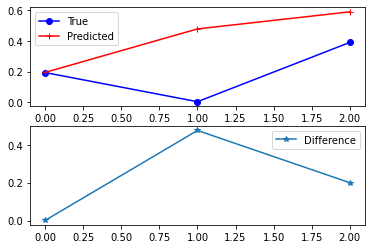

In [ ]:
new=data[:,:,64,74]
#print(new)
#print(new.shape)
new_normal = np.zeros((115,12,1,1))
new = np.where(new<0,0,new)
"""
for i in range(len(years)):
  for j in range(len(months)):
    new_normal[i,j,:,:] = preprocessing.normalize(new[i,j,:,:])
"""
for m in range(1):
  new_monthly = new[:,m]
  grid = new_monthly.reshape(115,1)
  #print(grid)
  rnn_predict(grid)

In [ ]:
reqdata = np.zeros((115,12,21,25))
normal_data = np.zeros_like(reqdata)
reqdata = data[:,:,44:65,60:85]
reqdata = np.where(reqdata<0,0,reqdata)
print(reqdata.shape)

for i in range(len(years)):
  for j in range(len(months)):
    normal_data[i,j,:,:] = preprocessing.normalize(reqdata[i,j,:,:])

(115, 12, 21, 25)


**Predicting for each grid monthly**

(115, 21, 25)
(100, 1) (15, 1)
before split= (115, 1)
shape of train ata= (97, 3, 1) (97, 1)
shape of test ata= (12, 3, 1) (12, 1)
fitting done
preict1 done
preict2 done
testrmse=  0.34535707241650115
trainscore=  0.16131158922186623
outpt shape(test)= (12, 1)
outpt shape(train)= (97, 1)


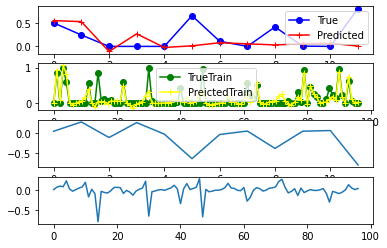

In [ ]:
jan = normal_data[:,0,:,:]
print(jan.shape)
score = np.zeros((21,25))
for m in range(1):
  monthly_data = normal_data[:,m,:,:]
  for i in range(1):
    for j in range(1):
      grid=monthly_data[:,i,j].reshape(115,1)
      
      rnn_predict(grid)
      